In [353]:
%matplotlib inline


## Finite-Time Domain Approximation for 2D Elliptic Poisson Equation
We have defined this problem to be a 2D Elliptic Poisson Equation that's homogenous but with additional terms for the first partial spatial derivative of variables x and y. 

--------------------------------------------------------------------------

To solve this problem numerically, we must perform a finite-difference approximation using central (second partial derivative and first partial) finite difference. This approach utilizes a 5-point stencil moving across the entire 2D grid but vectorized to speed-up computation.

---------------------------------------------------------------------------

Originally, I thought of utilizing the Linear Algebra approach, but this can become computationally intensive for storing large matrix values (I tried with a 100x100 grid with linear algebra approach it required about 12GB of RAM). The next option I found online was using a Jacobi iteration for solving PDEs, formally known as Jacobi relaxation method, implemented in a vectorized NumPy fashion.

In [354]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad


## Fokker Planck Equation at steady state is reduced to: 
$$ \frac{1}{2} \sigma^2 \nabla^2 P_{ss} - \frac{\partial}{\partial x}(\mu_x Pss) - \frac{\partial}{\partial y}(\mu_y P_{ss}) = 0 $$

By applying the Central Finite Difference Approximation, this equation can be reduced to (through algebraic manipulations) to 

$$ P[i, j] =  \frac{1}{\beta} ({\kappa (\frac{P[i+1,j]+P[i-1,j]}{\Delta x^2} + \frac{P[i+1,j]+P[i,j-1]}{\Delta y^2}) - \mu_x \frac{P[i+1,j]- P[i, j-1]}{2\Delta x} - \mu_y \frac{P[i,j+1]-P[i,j-1]}{2\Delta y}})$$

## Vectorized version of the code

In [355]:
""""
To run the simulation, we need initial conditions and boundary conditions. I set the initial conditions
to be equal to a bivariate gaussian with zero mean which was true for the analytical case I believe from what
you showed me you derived analytically
"""

# Initial conditions set to the analytical 
def AnalyticalSolution(x, y, mu_x=0, mu_y=0, sigma_x=1, sigma_y=1, rho=0):
    norm = 1.0 / (2* np.pi * sigma_x * sigma_y * np.sqrt(1-rho**2))

    # Exponent
    x_term = ((x - mu_x)**2) / sigma_x **2
    y_term = ((y- mu_y)**2) / sigma_y**2
    xy_term = (2 * rho * (x-mu_x) * (y - mu_y)) / (sigma_x * sigma_y)

    expo = -1.0 / (2 * (1- rho**2)) * (x_term - xy_term + y_term)

    return norm * np.exp(expo)


### Approach addressing challenges to Jacobi iteration method

###
The PDE updates uses a 5-point stencil that is updated from its four neighbors, but, on a square grid, the stencil never couples a node to itself (only copules to the opposite grids), leading to a checkerboard pattern. The Jacobi iteration only updates every node from the old grid, splitting the grid into two disjoint sets. To visualize this, let the center node be the "red" and the neighboring nodes be the "black". The red nodes are updated only from black nodes, and black nodes update only from the red, which leaves a checkerboard mode solution.

### Solution: Red-Black Gauss-Seidel 
1. Coloring the grid like a chessboard.
2. First update all red points using current black values.
3. Then update all black points using the newly updated reds.
This solution couples the two sub-lattices within a single sweep. 


This algorithim addresses the numerical instability of the Central Finite Difference Approximation for the first-partial derivative (drift terms) by using the sign of $\mu_x$ known as upwind differencing.  

The standard method is as follows:

If $\mu_x > 0$, the characteristic flows from the left, so we must use a forward difference:  

                (p[i+1, j] - p[i-1,j])/Dx

If $\mu_x < 0$, flow comes from the right, so we must use a forward difference:  

                (p[i+1,j] - p[i,j])/Dx

In [356]:
%%time
def sweep_dirichlet(p, MUx, MUy, MUxx, MUyy, beta, kappa, Dx, Dy, bc_value=0.0, omega=1.0):
    """
    One Jacobi sweep: returns p_new with interior updated and edges kept fixed.
    Dirichlet ghost cells outside the domain are set to bc_value.
    """

    # 1) Pad with a 1-cell ghost layer so neighbors are always addressable
    P = np.pad(p, 1, mode='constant', constant_values=float(bc_value))
    # P = np.pad(p, 1, mode='edge') # Neumann BC

    up = P[0:-2, 1:-1] # p[i-1, j]
    down = P[2: , 1:-1] # p[i+1, j]
    left = P[1:-1, 0:-2] # p[i, j-1]
    right = P[1:-1, 2: ] # p[i, j+1]
    center = P[1:-1, 1:-1] # p[i,j]

    # 2) Building the 5-piece stencil
    
    # Diffusion (second derivatives)

    lap_x = (down + up) / Dx**2    # uses i /pm 1, j --> x-direction second diff
    lap_y = (right + left) / Dy**2 # uses i, j \pm 1 --> y-direction second diff
    diff = kappa * (lap_x + lap_y)

    # 3) stabilization of first derivative differential (advection)
    dpdx_back = (center - up) / Dx  # used if MUx >= 0 (flow from up to center)
    dpdx_forw = (down - center) / Dx # used if MUx < 0 (flow from center to down)
    adv_x = np.where(MUx >= 0.0, MUx * dpdx_back, MUx * dpdx_forw)

    # partial derivative in y
    dpdy_back = (center - left) / Dy  # used if MUy >= 0
    dpdy_forw = (right - center) / Dy # used if MUy < 0
    adv_y = np.where(MUy >= 0.0, MUy * dpdy_back, MUy * dpdx_forw)


    # 4) Full interior update, allowing for MUxx + MUyy on the diagonal
    denom = (beta + MUxx + MUyy)
    eps = 1e-12
    denom = np.where(np.abs(denom) < eps, np.sign(denom)*eps, denom) #Guards against accidental zero/negatives

    rhs = (diff - (adv_x + adv_y)) / denom  # the raw Jacobi value

    # Addressing the decoupling issue so at each center of the stencil, it computes values 
    # of previous grids
    Nx, Ny = p.shape
    I, J = np.ogrid[:Nx, :Ny]
    red = ((I + J) % 2) == 0
    black = ~red

    p_new = p.copy()
    # Gauss-Seidel with relaxation: update red using latest blacks (from p), then update blacks using latest reds
    p_new[red] = (1 - omega) * p[red] + omega * rhs[red]
    # refresh the padded center for the second color to see the latest updates
    P = np.pad(p_new, 1, mode='constant', constant_values=float(bc_value))
    center = P[1:-1, 1:-1]
    up = P[0:-2, 1:-1]
    down = P[2: , 1:-1]
    left = P[1:-1, 0:-2]
    right = P[1:-1, 2: ]
    #recompute the parts  needed for black grids
    lap_x = (down + up) / (Dx*Dy)
    lap_y = (right + left) / (Dx*Dy)
    diff = kappa * (lap_x + lap_y)
    dpdx_back = (center - up) / Dx
    dpdx_forw = (down - center) / Dx
    adv_x = np.where(MUx >= 0.0, MUx * dpdx_back, MUx * dpdx_forw)
    dpdy_back = (center - left) / Dy
    dpdy_forw = (right - center) / Dy
    adv_y = np.where(MUy >= 0.0, MUy * dpdy_back, MUy * dpdy_forw)
    rhs_black = (diff - (adv_x + adv_y)) / denom

    p_new[black] = (1 - omega) * p[black] + omega * rhs_black[black]


    # 5) Ensuring positive values for PDF 
    p_new = np.maximum(p_new, 0.0)
    mass = p_new.sum() * Dx * Dy
    if mass > 0.0:
        p_new /= mass

    return p_new


CPU times: user 13 µs, sys: 110 µs, total: 123 µs
Wall time: 404 µs


### Setting up the 2D simulation grid parameters

In [357]:
# Number of nodes in x and y direction 
Nx = 500
Ny = 500

# Interval for x and y values
Xmin = 0.0
Xmax = 5.0
Ymin = 0.0
Ymax = 5.0

x = np.linspace(Xmin, Xmax, Nx)
y = np.linspace(Ymin, Ymax, Ny)

# Constant change in x and y 
Dx = x[1] - x[0]
Dy = y[1] - y[0]

x = np.asarray(x, dtype=np.float64)
y = np.asarray(y, dtype=np.float64)
Dx = float(x[1] - x[0])
Dy = float(y[1] - y[0])

# ---- initialize p, set Dirichlet edges from the analytic solution
p = np.zeros((Nx, Ny), dtype=np.float64)
p[0,:] = AnalyticalSolution(float(x[0]), y)
p[-1,:] = AnalyticalSolution(float(x[-1]), y)
p[:, 0] = AnalyticalSolution(x, float(y[0]))
p[:, -1] = AnalyticalSolution(x, float(y[-1]))

# grid 
X,Y = np.meshgrid(x,y, indexing="ij")

# parameters
gamma = 1.0
delta_omega = 4.0
alpha = 0.5 
C_g = 2.0
C_i = 0.0

# ----drift field \mu and its partials
MUx = -gamma*X - (delta_omega - alpha*(X**2 + Y**2))*Y + C_g
MUy = (delta_omega - alpha * (X**2 + Y**2))*X - gamma*Y + C_i
MUxx = -gamma + 2.0*alpha*X*Y
MUyy = -gamma - 2.0*alpha*X*Y

# diffusion constants
sigma = 1.0
kappa = 0.5 * sigma**2
beta = 2.0*kappa*(1.0/Dx**2 + 1.0/Dy**2) # scalar constant

p_init = p.copy()


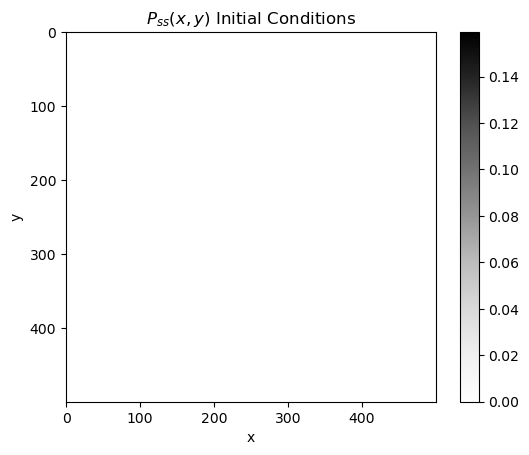

In [358]:
plt.imshow(p_init, cmap="Greys")
plt.title("$P_{ss}(x,y)$ Initial Conditions")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()


### Running the simulation with the number of iterations and maximum tolerance of error

min: 0.0 max: 0.5521500220912298 mass: 0.9999999999999992


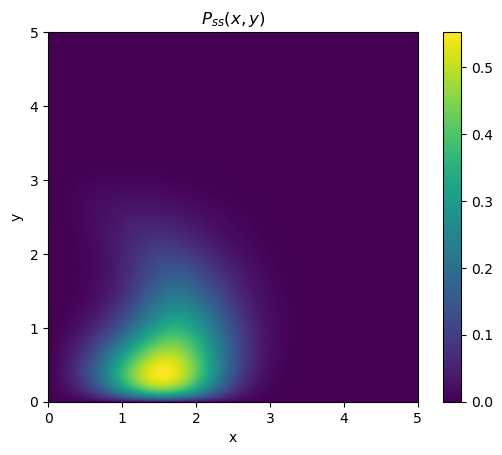

In [359]:
tol = 1e-10
max_iters = 10_000
omega = 1.0

for it in range(max_iters):
    p_next = sweep_dirichlet(p, MUx, MUy, MUxx, MUyy, beta, kappa, Dx, Dy, bc_value=0.0, omega=1.0)
    if not np.isfinite(p_next).all():
        raise FloatingPointError("Non-finite encountered during iteration")
    if np.max(np.abs(p_next - p)) < tol:
        p = p_next
        print(f"converged in {it+1} iters")
        break
    p = p_next

# normalizing_factor = np.sum(p)
# p = p/normalizing_factor
plt.imshow(p, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.title("$P_{ss}(x,y)$")
plt.xlabel("x")
plt.ylabel("y")

print("min:", p.min(), "max:", p.max(), "mass:", p.sum()*Dx*Dy)
